In [136]:
import GetOldTweets3 as got
from datetime import datetime, date, timedelta
import numpy as np 
import pandas as pd
import csv
import re
import nltk 
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm
from arch.unitroot import ADF
from nltk.corpus import stopwords
from statsmodels.tsa.arima_model import ARIMA
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas_datareader import data
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf
%matplotlib inline

#### Approach:
In order to give sentiment analysis, we have decided to use NLP. We will complete the tasks in this order:
1. Extract Trump's tweets
2. Extract the data of labeled twitter dataset so we can train a supervised model on it
3. Train a NLP model on it
4. Use the trained model to evaluate tweet sentiment

## Downloading Trump's tweets

<b>Important to note:</b> Twitter blocks the scraping if we are pulling too many tweets. The code below is just for show, do not launch it. We managed to pull tweets all the wayback from 2016 with multiple launches.

In [6]:
# with open("influencersTweets.csv", 'w', encoding="utf-8") as f:
#    # Wrap the file object by the writer.
#    writer = csv.writer(f)
   
#    # Write the header line to the output if needed.
#    writer.writerow(['username','date', 'tweet'])
   
#    start = date(2019, 5, 23)
#    end = date.today()
#    day = timedelta(days=1)

#    mydate = start
   
#    while mydate < end:
           
#        print("{date.day:02}{date.month:02}{date.year}".format(date=mydate))
       
#        tweetCriteria = got.manager.TweetCriteria().setUsername("realDonaldTrump")\
#                                           .setSince(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate)))\
#                                           .setUntil(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate+day)))\
#                                           .setTopTweets(True)\
#                                           .setMaxTweets(240)\
#                                           .setEmoji("unicode")
       
#        mydate = mydate + day
    
#        for tweets in got.manager.TweetManager.getTweets(tweetCriteria):
#            #writer.writerow(t)

#            writer.writerow([tweets.username, tweets.date, tweets.text])

In [7]:
pd.read_csv('influencersTweets.csv').head()

## NLP Model Setup

### Airline data import

In [34]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

### Data processing

In [37]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [38]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

### TF-IDF vectorization

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/semen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
vectorizer = TfidfVectorizer (max_features=2300, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [42]:
processed_features.shape

(14640, 2300)

### Training

In [43]:
y_train = labels
X_train = processed_features

In [44]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Making sentiment predictions on Trump's tweets

###  Dataset import and processing

In [45]:
tweets_df = pd.read_csv('Trump_Tweets')

In [46]:
tweets_df

,Unnamed: 0,date,tweet
0,0,2016-01-01 23:40:51+00:00,The person that Hillary Clinton least wants to...
1,1,2016-01-01 23:25:54+00:00,"""@codyraymille: I have never been interested i..."
2,2,2016-01-01 23:24:13+00:00,I will be going to Mississippi tomorrow night ...
3,3,2016-01-01 23:10:25+00:00,"""@CASuperrunner: @georgehenryw Huckabee is a g..."
4,4,2016-01-01 23:08:18+00:00,"""@MEMEoryHead: I'm one of your biggest fans Mr..."
...,...,...,...
14754,2166,2020-03-22 03:56:31+00:00,NaN
14755,2167,2020-03-22 03:46:46+00:00,Thank you @JennPellegrino @OANN
14756,2168,2020-03-22 03:19:31+00:00,"Thank you David, so true!"
14757,2169,2020-03-22 03:14:05+00:00,Thank you!


In [47]:
tweets = tweets_df.iloc[:, 2].values

In [48]:
processed_tweets = []

for sentence in range(0, len(tweets)):
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', str(tweets[sentence]))

    # remove all single characters
    processed_tweet= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)

    # Remove single characters from the start
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 

    # Substituting multiple spaces with single space
    processed_tweet = re.sub(r'\s+', ' ', processed_tweet, flags=re.I)

    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)

    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()

    processed_tweets.append(processed_tweet)

In [49]:
vectorizer = TfidfVectorizer (max_features=2300, min_df=13, max_df=0.8, stop_words=stopwords.words('english'))
vectorized_tweets = vectorizer.fit_transform(processed_tweets).toarray()

In [50]:
vectorized_tweets.shape

(14759, 2300)

###  Attributing sentiment to tweets

In [51]:
predictions = text_classifier.predict(vectorized_tweets)

In [52]:
pred_df = pd.DataFrame(predictions, columns=['sentiment'])
pred_df.sentiment.value_counts()

negative    13972
positive      421
neutral       366
Name: sentiment, dtype: int64

## Making  the Time Series of Sentiment

In [53]:
sentiment_df = pd.concat([tweets_df.drop(tweets_df.columns[0], axis=1),pred_df], axis=1)
sentiment_df

,date,tweet,sentiment
0,2016-01-01 23:40:51+00:00,The person that Hillary Clinton least wants to...,negative
1,2016-01-01 23:25:54+00:00,"""@codyraymille: I have never been interested i...",negative
2,2016-01-01 23:24:13+00:00,I will be going to Mississippi tomorrow night ...,negative
3,2016-01-01 23:10:25+00:00,"""@CASuperrunner: @georgehenryw Huckabee is a g...",negative
4,2016-01-01 23:08:18+00:00,"""@MEMEoryHead: I'm one of your biggest fans Mr...",negative
...,...,...,...
14754,2020-03-22 03:56:31+00:00,NaN,negative
14755,2020-03-22 03:46:46+00:00,Thank you @JennPellegrino @OANN,negative
14756,2020-03-22 03:19:31+00:00,"Thank you David, so true!",negative
14757,2020-03-22 03:14:05+00:00,Thank you!,negative


### Clean the dates

In [64]:
sentiment_df['clean_datetime'] = sentiment_df['date'].apply(lambda x: x[:10])

In [66]:
sentiment_df

,date,tweet,sentiment,clean_datetime
0,2016-01-01 23:40:51+00:00,The person that Hillary Clinton least wants to...,negative,2016-01-01
1,2016-01-01 23:25:54+00:00,"""@codyraymille: I have never been interested i...",negative,2016-01-01
2,2016-01-01 23:24:13+00:00,I will be going to Mississippi tomorrow night ...,negative,2016-01-01
3,2016-01-01 23:10:25+00:00,"""@CASuperrunner: @georgehenryw Huckabee is a g...",negative,2016-01-01
4,2016-01-01 23:08:18+00:00,"""@MEMEoryHead: I'm one of your biggest fans Mr...",negative,2016-01-01
...,...,...,...,...
14754,2020-03-22 03:56:31+00:00,NaN,negative,2020-03-22
14755,2020-03-22 03:46:46+00:00,Thank you @JennPellegrino @OANN,negative,2020-03-22
14756,2020-03-22 03:19:31+00:00,"Thank you David, so true!",negative,2020-03-22
14757,2020-03-22 03:14:05+00:00,Thank you!,negative,2020-03-22


### Score sentiment

<b>Rule</b> :
- Positive = 1
- Neutral = 0
- Negative = -1

In [67]:
def score_sentiment(sentiment):
    if sentiment == "negative":
        sentiment_score = -1
    elif sentiment == "positive":
        sentiment_score = 1
    elif sentiment == "neutral":
        sentiment_score = 0
    return sentiment_score

In [68]:
sentiment_df['sentiment_score'] = sentiment_df['sentiment'].apply(lambda x: score_sentiment(x))

### Constructing a time series

<b>Rule</b> : We will aggregate the sentiment score by summing the sentiment score  daily

In [70]:
time_series_df = sentiment_df.groupby([sentiment_df['clean_datetime']]).sum()
time_series_df

,sentiment_score
clean_datetime,
2016-01-01,-14
2016-01-02,-8
2016-01-03,-14
2016-01-04,-3
2016-01-05,-10
...,...
2020-03-18,-16
2020-03-19,-6
2020-03-20,-4


In [71]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

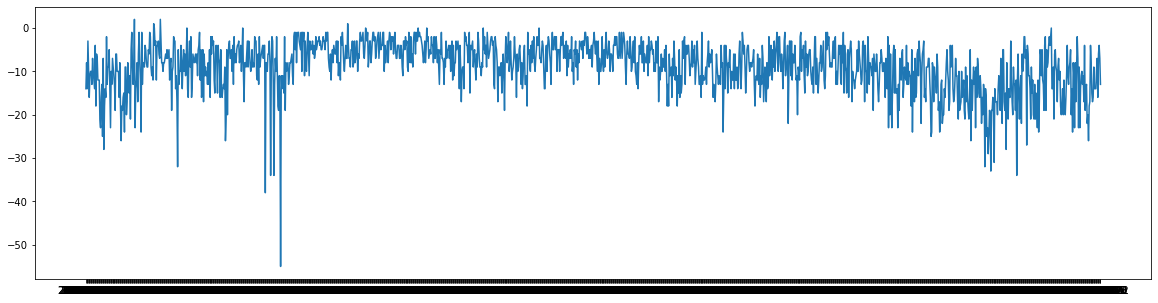

In [73]:
x = time_series_df.index
y = time_series_df['sentiment_score']
plt.figure(figsize=(20,5))
plt.plot(x,y)
plt.show()

### Evaluating the time series

In [74]:
time_series_df.describe()

,sentiment_score
count,1528.000000
mean,-8.868455
std,5.797192
min,-55.000000
25%,-12.000000
50%,-8.000000
75%,-5.000000
max,2.000000


### Test stationarity

In [77]:
# Augmented DF Test
adf = ADF(y)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.917
P-value                         0.002
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Here p-value < 0.05 so we reject the null hypothesis and conclude that the Time Series is stationary

### Autocorrelation Function

/Users/semen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


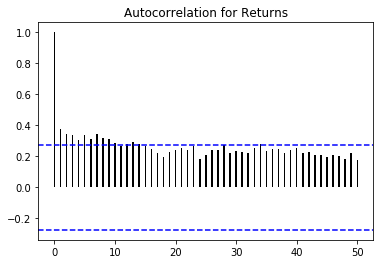

In [80]:
MAACF = acf(y, nlags=50)
x = range(0,51)
plt.bar(x,MAACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.title('Autocorrelation for Returns')
plt.show()

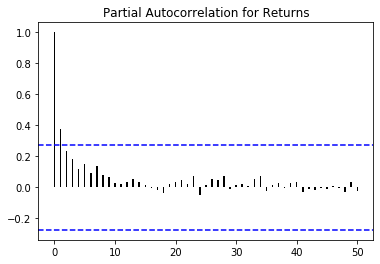

In [82]:
MAPACF = pacf(y, nlags=50)
x = range(0,51)
plt.bar(x,MAPACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.title('Partial Autocorrelation for Returns')
plt.show()

We can observe very large lag in the ACF.

### Fit an ARMA model

In [173]:
model = ARIMA(y, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/semen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:        sentiment_score   No. Observations:                 1528
Model:                     ARMA(1, 1)   Log Likelihood               -4609.088
Method:                       css-mle   S.D. of innovations              4.939
Date:                Fri, 27 Mar 2020   AIC                           9226.176
Time:                        00:42:43   BIC                           9247.503
Sample:                             0   HQIC                          9234.113
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.9850      0.894    -10.053      0.000     -10.737      -7.233
ar.L1.sentiment_score     0.9815      0.007    143.725      0.000       0.968       0.995
ma.L1.se

#### We can also plot residual errors

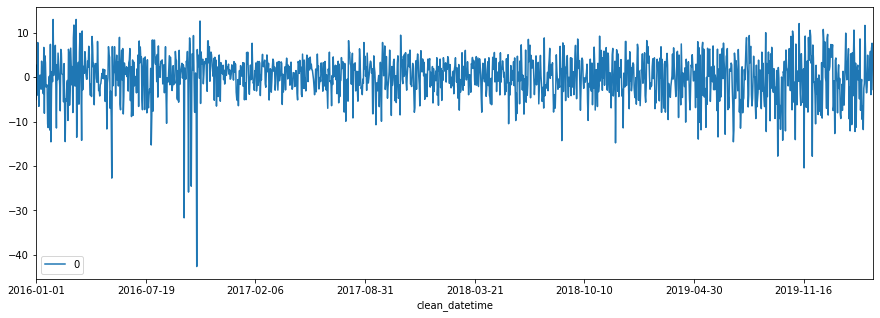

In [110]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize = (15,5))

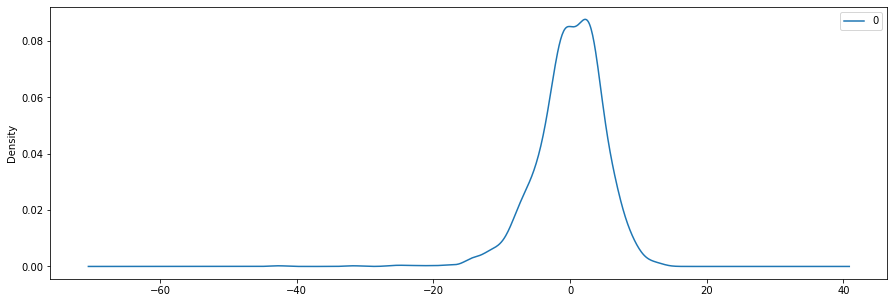

In [111]:
# Residuals density
residuals.plot(figsize = (15,5), kind='kde')

We can observe that the residuals look Gaussian which is a good sign

/Users/semen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


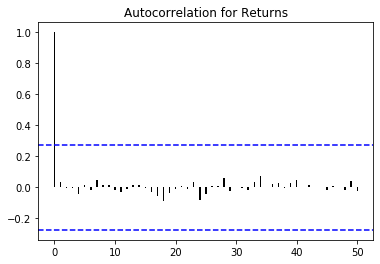

In [112]:
MAres2 = model_fit.resid
MAACF = acf(MAres2, nlags=50)
x = range(0,51)
plt.bar(x,MAACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.title('Autocorrelation for Returns')
plt.show()

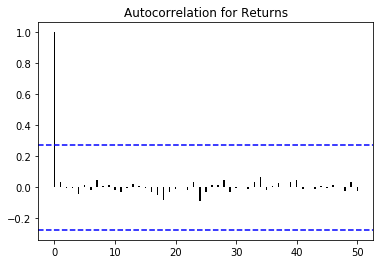

In [113]:
MAres = model_fit.resid
MAPACF = pacf(MAres, nlags=50)
x = range(0,51)
plt.bar(x,MAPACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.title('Autocorrelation for Returns')
plt.show()

<b> For tweets we found ARMA(1, 1) process to be the one with lowest AIC and BIC criteria</b>

## Question 4

In [116]:
start_date, end_date = '2016-01-01', '2020-01-01'
SnP = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
SnP['Log'] = np.log(SnP['Adj Close'])
SnP['Returns'] = np.append(0,np.diff(SnP['Log']))
SnP = SnP['Returns']

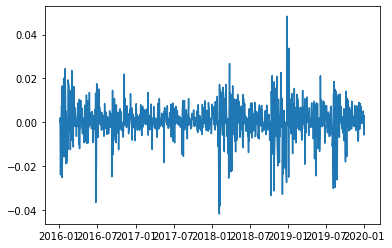

In [117]:
plt.plot(SnP)
plt.show()

In [118]:
#For the level
adf = ADF(SnP)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -12.264
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


/Users/semen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


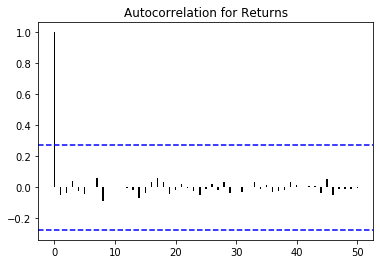

In [119]:
MAACF = acf(SnP.values, nlags=50)
x = range(0,51)
plt.bar(x,MAACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.title('Autocorrelation for Returns')
plt.show()

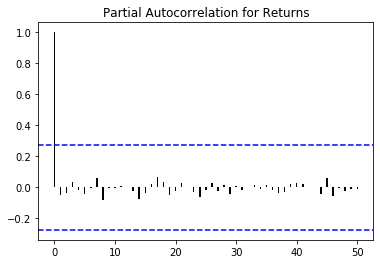

In [120]:
MAPACF = pacf(SnP.values, nlags=50)
x = range(0,51)
plt.bar(x,MAPACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.title('Partial Autocorrelation for Returns')
plt.show()

In [166]:
model = ARIMA(SnP.values, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1006
Model:                     ARMA(2, 1)   Log Likelihood                3420.209
Method:                       css-mle   S.D. of innovations              0.008
Date:                Fri, 27 Mar 2020   AIC                          -6830.417
Time:                        00:38:09   BIC                          -6805.849
Sample:                             0   HQIC                         -6821.082
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.974      0.048    3.27e-06       0.001
ar.L1.y       -0.9194      0.116     -7.925      0.000      -1.147      -0.692
ar.L2.y       -0.0766      0.032     -2.384      0.0

In [122]:
model_fit.params #coef param
model_fit.cov_params() #cov matrix

array([[ 1.53873222e-09,  1.34863622e-08,  8.63387250e-13],
       [ 1.34863622e-08,  4.21352674e-05, -8.04666755e-10],
       [ 8.63387250e-13, -8.04666755e-10,  1.39789153e-05]])

/Users/semen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


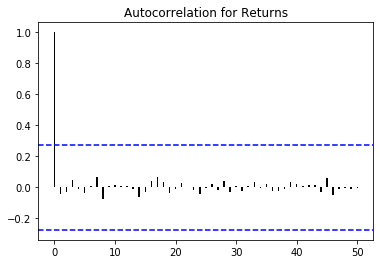

In [123]:
MAres2 = model_fit.resid
MAACF = acf(MAres2, nlags=50)
x = range(0,51)
plt.bar(x,MAACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAACF)),linestyle='--',color='b')
plt.title('Autocorrelation for Returns')
plt.show()

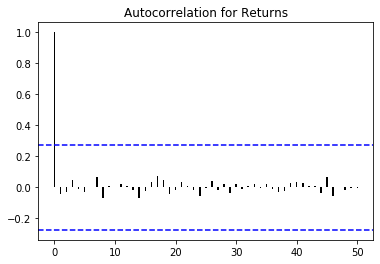

In [124]:
MAres = model_fit.resid
MAPACF = pacf(MAres, nlags=50)
x = range(0,51)
plt.bar(x,MAPACF,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(MAPACF)),linestyle='--',color='b')
plt.title('Autocorrelation for Returns')
plt.show()

<b>For S&P 500 we came up with ARMA(1,1) model as it had the lowest AIC and BIC criterias</b>

## Question 5

In [164]:
data_tuples = list(zip(list(SnP.values), list(y[3:-82].values)))

In [165]:
gc_res = grangercausalitytests(pd.DataFrame(data_tuples), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3322  , p=0.5645  , df_denom=1002, df_num=1
ssr based chi2 test:   chi2=0.3332  , p=0.5638  , df=1
likelihood ratio test: chi2=0.3332  , p=0.5638  , df=1
parameter F test:         F=0.3322  , p=0.5645  , df_denom=1002, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8628  , p=0.4223  , df_denom=999, df_num=2
ssr based chi2 test:   chi2=1.7341  , p=0.4202  , df=2
likelihood ratio test: chi2=1.7326  , p=0.4205  , df=2
parameter F test:         F=0.8628  , p=0.4223  , df_denom=999, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7769  , p=0.5070  , df_denom=996, df_num=3
ssr based chi2 test:   chi2=2.3470  , p=0.5036  , df=3
likelihood ratio test: chi2=2.3442  , p=0.5041  , df=3
parameter F test:         F=0.7769  , p=0.5070  , df_denom=996, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9035  , p=0.4612

<b>Having tested for Granger casuality we found that Donald Trump's tweets were not sufficient to forecast S&P 500 returns as P-value is higher than 0.1 </b>